**Описание проекта**

Компания «Мегалайн» — федеральный оператор сотовой связи.
Клиентам предлагают два тарифных плана: «Смарт» и «Ультра».
Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. 
Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.


*Описание тарифов*

Тариф «Смарт»
1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
o	минута разговора: 3 рубля
o	сообщение: 3 рубля
o	1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»
1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
o	минута разговора: 1 рубль
o	сообщение: 1 рубль
o	1 Гб интернет-трафика: 150 рублей

Примечание:

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.


**1. Изучение исходных данных**

In [1]:
import pandas as pd # импорт библиотек
import numpy as np
import math

In [2]:
df_calls = pd.read_csv('/datasets/calls.csv') # вывод таблицы данных по звонкам пользователей
display(df_calls.head())
df_calls.info()
df_calls.isna().sum() # вывод количества пропусков

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [3]:
df_calls['user_id'].value_counts()

1377    1760
1168    1692
1375    1560
1453    1440
1196    1240
        ... 
1397      33
1442      28
1373      24
1016      20
1257      14
Name: user_id, Length: 492, dtype: int64

•	*id — уникальный номер звонка*

•	*call_date — дата звонка*

•	*duration — длительность звонка в минутах*

•	*user_id — идентификатор пользователя, сделавшего звонок*


По данной таблице необходимо:
1. округлить минуты до целочисленного типа
2. дату привести к типу данных "datetime"
3. добавить новый столбец "месяц"
4. удалить явные дубликаты


In [4]:
df_internet = pd.read_csv('/datasets/internet.csv') # вывод таблицы данных по интернет-трафику пользователей
display(df_internet.head())
df_internet.info()
df_internet.isna().sum()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

In [5]:
df_internet['user_id'].value_counts()

1496    834
1227    812
1204    789
1240    764
1251    759
       ... 
1151     35
1467     27
1343     26
1192     22
1399      8
Name: user_id, Length: 497, dtype: int64

•	*id — уникальный номер сессии*

•	*mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)*

•	*session_date — дата интернет-сессии*

•	*user_id — идентификатор пользователя*


По данной таблице необходимо:
1. удалить столбец "Unnamed: 0"
2. дату привести к типу данных "datetime"
3. добавить новый столбец "месяц"
4. удалить явные дубликаты

In [6]:
df_messages = pd.read_csv('/datasets/messages.csv') # вывод таблицы данных по количеству сообщений пользователей
display(df_messages.head())
df_messages.info()
df_messages.isna().sum()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


id              0
message_date    0
user_id         0
dtype: int64

In [7]:
df_messages['user_id'].value_counts()

1277    1463
1089    1408
1231    1384
1385    1380
1356    1224
        ... 
1389       6
1279       5
1074       3
1159       2
1141       1
Name: user_id, Length: 426, dtype: int64

•	*id — уникальный номер сообщения*

•	*message_date — дата сообщения*

•	*user_id — идентификатор пользователя, отправившего сообщение*


По данной таблице необходимо:
1. дату привести к типу данных "datetime"
2. добавить новый столбец "месяц"
4. удалить явные дубликаты

In [8]:
df_tariffs = pd.read_csv('/datasets/tariffs.csv') # вывод таблицы данных с параметрами тарифов
display(df_tariffs.head())
df_tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


•	*tariff_name — название тарифа*

•	*rub_monthly_fee — ежемесячная абонентская плата в рублях*

•	*minutes_included — количество минут разговора в месяц, включённых в абонентскую плату*

•	*messages_included — количество сообщений в месяц, включённых в абонентскую плату*

•	*mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)*

•	*rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)*

•	*rub_per_message — стоимость отправки сообщения сверх тарифного пакета*

•	*rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)*


In [9]:
df_users = pd.read_csv('/datasets/users.csv') # вывод таблицы данных с данными пользователей
display(df_users.head())
df_users.info()
df_users.isna().sum()
df_users['city'].unique()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

•	*user_id — уникальный идентификатор пользователя*

•	*first_name — имя пользователя*

•	*last_name — фамилия пользователя*

•	*age — возраст пользователя (годы)*

•	*reg_date — дата подключения тарифа (день, месяц, год)*

•	*churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)*

•	*city — город проживания пользователя*

•	*tarif — название тарифного плана*


По данной таблице необходимо:
1. дату привести к типу данных "datetime"
2. добавить столбец месяц включения и месяц выключения
3. удалить явные дубликаты

**1. Вывод:**

1.Данные представлены чистыми, без пропусков.

2. Необходимо заменить типы данных.
3. Преобразовать таблицы перед объединением.

**2. Подготовка данных**

1. Преобразуем первую таблицу с данными по звонкам

In [10]:

df_calls['duration'] = np.ceil(df_calls['duration']) # округляем длительность звонка до минут в большую сторону
df_calls['duration'] = df_calls['duration'].astype('int') # преобразуем данные в целочисленный тип

df_calls['call_date'] = pd.to_datetime(df_calls['call_date']) # преобразуем данные столбца в тип "datetime"

df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month # добавим столбец "месяц звонка"

display(df_calls.duplicated().sum()) # вывод количества дубликатов (0)

display(df_calls.head())
df_calls.info()

0

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int64
user_id      202607 non-null int64
month        202607 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 7.7+ MB


In [11]:
df_calls_user = df_calls.groupby(['user_id','month'])['duration'].sum()
#df_calls_user = df_calls.pivot_table(index= 'user_id', columns = 'month', values = 'duration', aggfunc = 'sum') # вывод сводной таблицы длительности звонков по месяцам каждого пользователя
df_calls_user = df_calls_user.reset_index()

df_calls_user = df_calls_user.fillna(0) # замена NaN на нули
df_calls_user.head(12)

,user_id,month,duration
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466
5,1000,10,350
6,1000,11,338
7,1000,12,333
8,1001,11,430
9,1001,12,414


In [12]:
df_calls_user['user_id'].value_counts()

1496    12
1375    12
1302    12
1282    12
1337    12
        ..
1406     1
1434     1
1223     1
1252     1
1336     1
Name: user_id, Length: 492, dtype: int64

2. Преобразуем вторую таблицу с данными по интернет трафику

In [13]:
#display(df_internet.head())
df_internet = df_internet.drop('Unnamed: 0', axis = 1) # удалим столбец Unnamed: 0

df_internet['session_date'] = pd.to_datetime(df_internet['session_date']) # преобразуем данные столбца в тип "datetime"

df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month # добавим столбец "месяц интернет"

display(df_internet.duplicated().sum()) # вывод количества дубликатов (0)
display(df_internet.head())
#df_internet.info()

0

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


In [14]:
df_internet_user = df_internet.groupby(['user_id','month'])['mb_used'].sum()
#f_internet_user = df_internet.pivot_table(index= 'user_id', columns = 'month', values = 'mb_used', aggfunc = 'sum') #водной таблицы объема интернет-трафика по месяцам каждого пользователя
df_internet_user = df_internet_user.reset_index()
df_internet_user = df_internet_user.fillna(0)
df_internet_user.head(12)


,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
5,1000,10,14702.49
6,1000,11,14756.47
7,1000,12,9817.61
8,1001,11,18429.34
9,1001,12,14036.66


In [15]:
df_internet_user['user_id'].value_counts()

1302    12
1299    12
1032    12
1055    12
1340    12
        ..
1131     1
1137     1
1387     1
1397     1
1234     1
Name: user_id, Length: 497, dtype: int64

3. Преобразуем третью таблицу с данными по смс сообщениям

In [16]:

df_messages['message_date'] = pd.to_datetime(df_messages['message_date']) # преобразуем данные столбца в тип "datetime"

df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month # добавим столбец "месяц сообщения"

df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
month           123036 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.8+ MB


In [17]:
df_messages_user = df_messages.groupby(['user_id','month'])['id'].count()
#df_messages_user = df_messages.pivot_table(index= 'user_id', columns = 'month', values = 'id', aggfunc = 'count') # вывод сводной таблицы количества сообщений по месяцам каждого пользователя
df_messages_user = df_messages_user.reset_index()
df_messages_user = df_messages_user.fillna(0)
df_messages_user.head(12)

,user_id,month,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


In [18]:
df_messages_user['user_id'].value_counts()

1005    12
1299    12
1401    12
1168    12
1395    12
        ..
1434     1
1387     1
1084     1
1074     1
1131     1
Name: user_id, Length: 426, dtype: int64

Объединим эти три таблицы по номеру пользователя и месяцу.

In [19]:
df = df_calls_user.merge(df_internet_user, on=['user_id','month'] , how='outer')
df = df.merge(df_messages_user, on=['user_id','month'] , how='outer')
df.head(12)



,user_id,month,duration,mb_used,id
0,1000,5,159.0,2253.49,22.0
1,1000,6,172.0,23233.77,60.0
2,1000,7,340.0,14003.64,75.0
3,1000,8,408.0,14055.93,81.0
4,1000,9,466.0,14568.91,57.0
5,1000,10,350.0,14702.49,73.0
6,1000,11,338.0,14756.47,58.0
7,1000,12,333.0,9817.61,70.0
8,1001,11,430.0,18429.34,NaN
9,1001,12,414.0,14036.66,NaN


**Комментарий студента:**
1. Посчитала количество уникальных пользователей во всех таблицах: в звонках, интеренете, сообщениях. Поэтому при объединении таблиц в одну присвоила параметру how значение right, а затем left.

**Комментарий студента V2:** 
Николай, я заменила значение параметра how.

In [20]:
display(df['user_id'].value_counts())# подсчет уникальных пользователей 

1238    12
1394    12
1429    12
1423    12
1155    12
        ..
1131     1
1137     1
1387     1
1397     1
1141     1
Name: user_id, Length: 498, dtype: int64

В данной таблице можно посмотреть сумму звонков, сумму сообщений и сумму интернет-трафика на каждого пользователя по месяцам.

4. Преобразуем пятую таблицу с данными по пользователям

In [21]:

df_users['reg_date'] = pd.to_datetime(df_users['reg_date']) # преобразуем данные столбца в тип "datetime"
df_users['churn_date'] = pd.to_datetime(df_users['churn_date']) # преобразуем данные столбца в тип "datetime"
df_users['month_on'] = pd.DatetimeIndex(df_users['reg_date']).month # добавим столбец "месяц включения тарифа"
df_users['month_off'] = pd.DatetimeIndex(df_users['churn_date']).month # добавим столбец "месяц включения тарифа"
df_users = df_users.drop(['age','first_name', 'last_name'], axis = 1) # удалим столбцы возраст и фио
df_users.info()
df_users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
user_id       500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
month_on      500 non-null int64
month_off     38 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 27.5+ KB


,user_id,churn_date,city,reg_date,tariff,month_on,month_off
0,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN
1,1001,NaT,Москва,2018-11-01,smart,11,NaN
2,1002,NaT,Стерлитамак,2018-06-17,smart,6,NaN
3,1003,NaT,Москва,2018-08-17,ultra,8,NaN
4,1004,NaT,Новокузнецк,2018-05-14,ultra,5,NaN
...,...,...,...,...,...,...,...
495,1495,NaT,Иркутск,2018-08-28,ultra,8,NaN
496,1496,NaT,Вологда,2018-01-27,smart,1,NaN
497,1497,NaT,Челябинск,2018-10-09,smart,10,NaN
498,1498,2018-10-25,Владикавказ,2018-07-19,smart,7,10.0


In [22]:
display(df_users['user_id'].value_counts()) #количество уникальных пользователей

1023    1
1194    1
1181    1
1182    1
1183    1
       ..
1362    1
1363    1
1364    1
1365    1
1024    1
Name: user_id, Length: 500, dtype: int64

5. Объединим таблицу с данными по трафику с таблицей с информацией о пользователях

In [23]:
df_1 = df_users.merge(df, on=['user_id'], how='left')

df_1['id'] = df_1['id'].fillna(0)
df_1['duration'] = df_1['duration'].fillna(0)
df_1['mb_used'] = df_1['mb_used'].fillna(0)
df_1.head(12)

,user_id,churn_date,city,reg_date,tariff,month_on,month_off,month,duration,mb_used,id
0,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,5.0,159.0,2253.49,22.0
1,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,6.0,172.0,23233.77,60.0
2,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,7.0,340.0,14003.64,75.0
3,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,8.0,408.0,14055.93,81.0
4,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,9.0,466.0,14568.91,57.0
5,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,10.0,350.0,14702.49,73.0
6,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,11.0,338.0,14756.47,58.0
7,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,12.0,333.0,9817.61,70.0
8,1001,NaT,Москва,2018-11-01,smart,11,NaN,11.0,430.0,18429.34,0.0
9,1001,NaT,Москва,2018-11-01,smart,11,NaN,12.0,414.0,14036.66,0.0


6. Внесем в данную таблицу данные по лимитам и стоимости тарифов

In [24]:

df_tariffs = df_tariffs.rename(columns={'tariff_name':'tariff'}) # переименуем столбец, для того чтобы в дальнейшем объединить две таблицы по столбцу "тариф"
display(df_tariffs.head())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [25]:
df_consolid = df_1.merge(df_tariffs, on=['tariff'], how='left') #объединяем таблицы в сводную таблицу
df_consolid.head()


,user_id,churn_date,city,reg_date,tariff,month_on,month_off,month,duration,mb_used,id,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,5.0,159.0,2253.49,22.0,1000,30720,3000,1950,150,1,1
1,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,6.0,172.0,23233.77,60.0,1000,30720,3000,1950,150,1,1
2,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,7.0,340.0,14003.64,75.0,1000,30720,3000,1950,150,1,1
3,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,8.0,408.0,14055.93,81.0,1000,30720,3000,1950,150,1,1
4,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,9.0,466.0,14568.91,57.0,1000,30720,3000,1950,150,1,1


7. Вычислим на каждого абонента помесячную выручку (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).). Для этого напишем функцию и применим ее к каждой строке датафрейма.

In [26]:
def income_month(row):
    b = row['rub_monthly_fee']
    if row['duration'] > row['minutes_included']:
        b = b + (row['duration'] - row['minutes_included']) * row['rub_per_minute']
    if row['id'] > row['messages_included']:
        b = b + (row['id'] - row['messages_included']) * row['rub_per_message']
    if row['mb_used'] > row['mb_per_month_included']:
        c = np.ceil((row['mb_used'] - row['mb_per_month_included']) / 1024)
        b = b + c * row['rub_per_gb']
    return b   

In [27]:
df_consolid['income'] = df_consolid.apply(income_month, axis=1) # Добавление столбца с помесячным доходом с каждого пользователя


In [28]:
df_consolid.head(20)

,user_id,churn_date,city,reg_date,tariff,month_on,month_off,month,duration,mb_used,id,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,income
0,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,5.0,159.0,2253.49,22.0,1000,30720,3000,1950,150,1,1,1950.0
1,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,6.0,172.0,23233.77,60.0,1000,30720,3000,1950,150,1,1,1950.0
2,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,7.0,340.0,14003.64,75.0,1000,30720,3000,1950,150,1,1,1950.0
3,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,8.0,408.0,14055.93,81.0,1000,30720,3000,1950,150,1,1,1950.0
4,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,9.0,466.0,14568.91,57.0,1000,30720,3000,1950,150,1,1,1950.0
5,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,10.0,350.0,14702.49,73.0,1000,30720,3000,1950,150,1,1,1950.0
6,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,11.0,338.0,14756.47,58.0,1000,30720,3000,1950,150,1,1,1950.0
7,1000,NaT,Краснодар,2018-05-25,ultra,5,NaN,12.0,333.0,9817.61,70.0,1000,30720,3000,1950,150,1,1,1950.0
8,1001,NaT,Москва,2018-11-01,smart,11,NaN,11.0,430.0,18429.34,0.0,50,15360,500,550,200,3,3,1150.0
9,1001,NaT,Москва,2018-11-01,smart,11,NaN,12.0,414.0,14036.66,0.0,50,15360,500,550,200,3,3,550.0


**2. Вывод**

В данном разделе соединили все таблицы в единую собрав все необходимые данные для анализа.
Посчитала доход с каждого пользователя.

In [29]:
df_consolid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 19 columns):
user_id                  3216 non-null int64
churn_date               189 non-null datetime64[ns]
city                     3216 non-null object
reg_date                 3216 non-null datetime64[ns]
tariff                   3216 non-null object
month_on                 3216 non-null int64
month_off                189 non-null float64
month                    3214 non-null float64
duration                 3216 non-null float64
mb_used                  3216 non-null float64
id                       3216 non-null float64
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per_minute           3216 non-null int64
income                   3216 non-null float64
dtypes: 

**3. Анализ данных**


1. Для анализа поведения абонентов каждого тарифа выясним сколько расходуют эти группы в среднем сообщений, минут разговора и интернет-трафика. 

In [30]:
df_tarif_user = df_consolid.groupby('tariff')['duration', 'mb_used', 'id'].mean()
display(df_tarif_user)

,duration,mb_used,id
tariff,,,
smart,417.747534,16201.118655,33.369058
ultra,526.089249,19449.059970,49.313387


In [31]:
display(df_tariffs.head())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В среднем абоненты тарифа smart перерасходуют только интернет-трафик. Остальные абоненты в среднем выдерживают лимиты отведенные тарифом.

2. Посчитаем среднее значение, дисперсию и стандартное отклонение по минутам звонков, смс сообщений и интернет-трафика для каждого тарифа .

In [32]:
smart = df_consolid.query('tariff == "smart"') # срез по тарифу смарт

In [33]:

c_sm = smart.groupby('month')['duration'].mean() # среднее тарифа Смарт по длительности звонков в каждом месяце
display(c_sm)


month
1.0     203.852941
2.0     298.689655
3.0     390.051948
4.0     367.133929
5.0     387.361702
6.0     395.640244
7.0     408.353234
8.0     421.468085
9.0     428.611538
10.0    426.136054
11.0    435.265823
12.0    478.560831
Name: duration, dtype: float64

In [34]:
c_sm.mean() # средняя сумма звонков по тарифу в месяц

386.76049870568664

In [35]:
np.var(c_sm, ddof=1) # дисперсия

5221.797220419809

In [36]:
np.std(c_sm, ddof=1) # стандартное отклонение

72.26200398840187

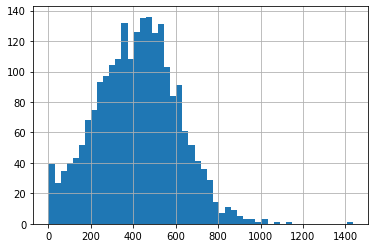

In [37]:
smart['duration'].hist(bins = 50)

Гистограмма распределена нормально. Это значит, что чаще всего встречаются среднее значение и близкие к нему. 
Большинство значений лежит в промежутке от 387-3 * 72 до 387+3 * 72= от 171 до 603 минут звонков большинство абонентов тарифа Смарт используют в месяц.   


In [38]:
mess_sm = smart.groupby('month')['id'].mean() # среднее для тарифа Смарт количество сообщений в каждом месяце
display(mess_sm)

month
1.0     18.235294
2.0     24.086207
3.0     31.857143
4.0     30.741071
5.0     33.773050
6.0     33.402439
7.0     33.751244
8.0     33.638298
9.0     33.638462
10.0    33.765306
11.0    34.075949
12.0    35.994065
Name: id, dtype: float64

In [39]:
mess_sm.mean() # среднее количество сообщений по тарифу в месяц

31.413210661085547

In [40]:
np.var(mess_sm, ddof=1) # дисперсия

26.0448270922888

In [41]:
np.std(mess_sm, ddof=1) # стандартное отклонение

5.103413278609601

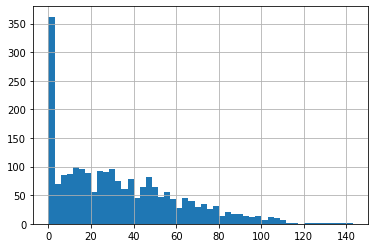

In [42]:
smart['id'].hist(bins = 50)

Гистограмма скошена вправо. Это значит, что чаще встречается значение, которое не является средним.
Большинство значений лежит в промежутке от 31-3* 5  до 31+3*5 = от 16 до 46 количество сообщений большинство абонентов тарифа Смарт используют в месяц.

In [43]:
mb_sm = smart.groupby('month')['mb_used'].mean() # среднее для тарифа Смарт количество мегабайт в каждом месяце
display(mb_sm)

month
1.0      8513.717647
2.0     11597.054310
3.0     15104.159091
4.0     13462.180625
5.0     15805.184326
6.0     15794.647988
7.0     15743.150348
8.0     16610.720085
9.0     16303.578808
10.0    16757.122891
11.0    16895.696646
12.0    18113.662047
Name: mb_used, dtype: float64

In [44]:
mb_sm.mean()  # среднее количество мегабайт в месяц по тарифу Смарт 

15058.406234384995

In [45]:
np.var(mb_sm, ddof=1) # дисперсия

7135321.341220865

In [46]:
np.std(mb_sm, ddof=1) # стандартное отклонение

2671.202227690907

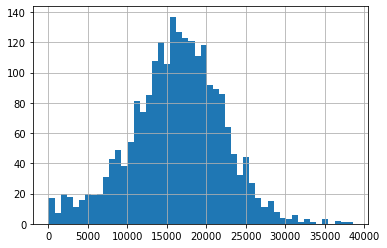

In [47]:
smart['mb_used'].hist(bins = 50) # вывод гистограммы

Гистограмма распределена нормально. Это значит, что чаще всего встречаются среднее значение и близкие к нему.
Большинство значений лежит в промежутке от 15064-3* 2675 до 15064+3*2675 = от 7039 до 23089 количество мегабайт большинство абонентов тарифа Смарт используют в месяц.

In [48]:
ultra = df_consolid.query('tariff == "ultra"') # срез по тарифу ультра

In [49]:
c_ult = ultra.groupby('month')['duration'].mean() # среднее тарифа Ультра по длительности звонков в каждом месяце
display(c_ult)

month
1.0     428.111111
2.0     297.125000
3.0     489.648649
4.0     458.018182
5.0     510.328358
6.0     479.702381
7.0     545.791209
8.0     510.775701
9.0     539.443478
10.0    558.081301
11.0    541.380597
12.0    592.805755
Name: duration, dtype: float64

In [50]:
c_ult.mean() # средняя сумма звонков по тарифу Ультра в месяц

495.9343101624627

In [51]:
c_ult.mean()  # средняя сумма звонков по тарифу Ультра в месяц

495.9343101624627

In [52]:
np.var(c_ult, ddof=1) # дисперсия

5998.513625261545

In [53]:
np.std(c_ult, ddof=1) # стандартное отклонение

77.45007182218454

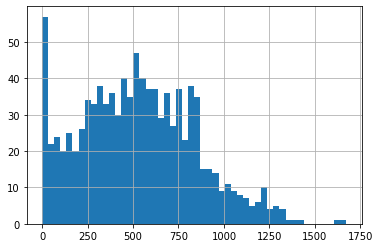

In [54]:
ultra['duration'].hist(bins = 50) # вывод гистограммы распределения звонков

Гистограмма распределена нормально. Есть выброс. Большинство значений лежит в промежутке от 499-3* 74 до 499+3*74 = от 277 до 721 количество минут звонков большинство абонентов тарифа Ультра используют в месяц.

In [55]:
mes_ult = ultra.groupby('month')['id'].mean() # среднее тарифа Ультра по количеству сообщений в каждом месяце
display(mes_ult)

month
1.0     33.777778
2.0     21.958333
3.0     32.297297
4.0     31.563636
5.0     37.850746
6.0     41.726190
7.0     49.846154
8.0     48.439252
9.0     52.286957
10.0    58.430894
11.0    55.791045
12.0    60.611511
Name: id, dtype: float64

In [56]:
mes_ult.mean() # среднее количество сообщений по тарифу Ультра в месяц


43.71498284147191

In [57]:
np.var(mes_ult, ddof=1) # дисперсия

151.79398765605353

In [58]:
np.std(mes_ult, ddof=1) # стандартное отклонение

12.320470269273553

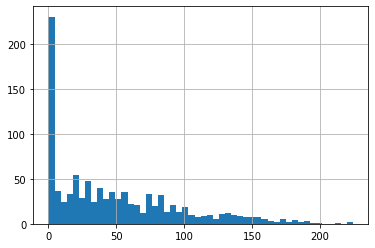

In [59]:
ultra['id'].hist(bins = 50) # вывод гистограммы распределения количества сообщений

Гистограмма скошена вправо. Это значит что, чаще всего встречается значение количества сообщений, котрое не является средним значением.  Большинство значений лежит в промежутке от 44-3* 12 до 44+3*12 = от 8 до 80 количество сообщений большинство абонентов тарифа Ультра используют в месяц.

In [60]:
mb_ult = ultra.groupby('month')['mb_used'].mean() # среднее тарифа Ультра по количеству мегабайт в каждом месяце
display(mb_ult)

month
1.0     13140.681111
2.0     11775.937500
3.0     17535.550270
4.0     16828.134364
5.0     19363.152985
6.0     18924.939286
7.0     20495.665165
8.0     19576.054673
9.0     19204.277130
10.0    20045.337317
11.0    19786.812463
12.0    21793.172590
Name: mb_used, dtype: float64

In [61]:
mb_ult.mean() # среднее количество мегабайт по тарифу Ультра в месяц

18205.809571138463

In [62]:
np.var(mb_ult, ddof=1) # дисперсия

8915742.05866276

In [63]:
np.std(mb_ult, ddof=1) # стандартное отклонение

2985.923987422111

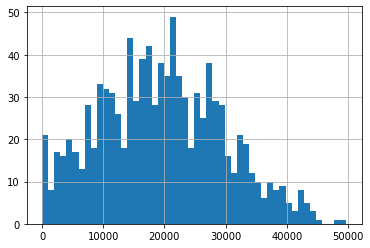

In [64]:
ultra['mb_used'].hist(bins = 50) # вывод гистограммы распределения количества мегабайт 

Гистограмма распределена нормально. Это значит, что чаще всего встречаются среднее значение и близкие к нему.
Большинство значений лежит в промежутке от 18426-3* 2865 до 18426+3*2865 = от 9831 до 27021 количество мегабайт большинство абонентов тарифа Ультра используют в месяц.

In [65]:
income_tarif_sum =df_consolid.groupby('tariff')['income'].sum() # сумма выручки с каждой группы пользователей
display(income_tarif_sum)

tariff
smart    2875901.0
ultra    2041050.0
Name: income, dtype: float64

In [66]:
user_tarif_sum =df_users.groupby('tariff')['user_id'].count() # количество пользователей каждой группы тарифа
display(user_tarif_sum)

tariff
smart    351
ultra    149
Name: user_id, dtype: int64

Посчитаем сколько в среднем пользователи заплатили компании за каждый тариф: годовую сумму выручки разделим на количество пользователей тарифа и разделим на 12 месяцев.

In [67]:
print('Стоимость тарифа Смарт в месяц для компании:', 2875351/351/12)   

Стоимость тарифа Смарт в месяц для компании: 682.6569325735992


In [68]:
print('Стоимость тарифа Ультра в месяц для компании:', 2023500/149/12)   

Стоимость тарифа Ультра в месяц для компании: 1131.7114093959733


Делаю вывод, что с учетом превышения лимитов по звонкам и интернет-трафику компания продала месячную подписку на тариф в 2018 году за 683 рубля. 

Делаю вывод, что с учетом того, что пользователей тарифа Ультра почти в два раза меньше, чем пользователей тарифа Смарт,  компания продала месячную подписку на тариф в 2018 году за 1132 рублей. 

In [69]:
df_tariffs


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


**3. Вывод**

1. Большинство пользователей тарифа Ультра не превышают лимитов по количеству интернет- трафика, по количеству смс сообщений, по количеству минут.
2. Большинство пользователей тарифа Смарт не превышают лимитов по смс- сообщениям. Часто пользователи тарифа Смарт превышают лимит по количеству интернет-трафика и минутам звонков.
3. Делаю вывод, что по результатам 2018 года тариф Смарт принес больше выручки для компании.
4. В среднем больше платит пользователь тарифа Ультра.
5. Гистограммы распределения для обоих тарифов имеют одинаковый тип. Для длительности звонков и для интернет-трафика гистограммы распределены нормально, чтоговорит о том что средние значения и близкие к ним имеют более высокую частоту встречаемости, чем другие значения. Гистограмма по количеству смс-сообщений имеет вид скошенный вправо, что значит что чаще среди пользователей встречается меньшее количество отправленных сообщений, но это значение не является средним количеством сообщений по всем пользователям или близким к нему.

**4. Проверка гипотез**

Проверим две гипотезы:

•	средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

•	средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.


Для проверки гипотез будем использовать статистический тест: Проверка гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.

*4.1 Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются*

Сформулируем нулевую гипотезу: средняя выручка пользователей тарифов равна.
Альтернативная гипотеза: средняя выручка пользователей разных тарифов не равна между собой.

In [70]:
income_smart = smart['income'] # выручка  с пользователей Смарт
display(income_smart)


8       1150.0
9        550.0
10       550.0
11      1150.0
12      1550.0
         ...  
3211    1750.0
3212     550.0
3213    1150.0
3214    1513.0
3215     598.0
Name: income, Length: 2230, dtype: float64

In [71]:
income_ultra = ultra['income'] # выручка с пользователей Ультра
display(income_ultra)

0       1950.0
1       1950.0
2       1950.0
3       1950.0
4       1950.0
         ...  
3188    1950.0
3189    2400.0
3190    1950.0
3191    3300.0
3192    1950.0
Name: income, Length: 986, dtype: float64

In [72]:
from scipy import stats as st

alpha = 0.05 

results = st.ttest_ind(income_smart, income_ultra, equal_var=True)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print(results.pvalue)    

Отвергаем нулевую гипотезу
8.081909555489933e-161


*4.2 Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.*

Сформулируем нулевую гипотезу: средняя выручка пользователей из Москвы равна средней выручке пользователей из регионов.
Альтернативная гипотеза: средняя выручка пользователей Москвы не равна средней выручке пользователей из регионов.

In [73]:
msk_user = df_consolid.query('city == "Москва"') # срез по пользователям из Москвы
msk_income = msk_user['income']
msk_income

8       1150.0
9        550.0
17      1950.0
18      1950.0
19      1950.0
         ...  
3160     950.0
3161     550.0
3162    1750.0
3163    1350.0
3164     750.0
Name: income, Length: 611, dtype: float64

In [74]:
reg_user = df_consolid.query('city != "Москва"') # срез по пользователям из регионов
reg_income = reg_user['income'] 
reg_income

0       1950.0
1       1950.0
2       1950.0
3       1950.0
4       1950.0
         ...  
3211    1750.0
3212     550.0
3213    1150.0
3214    1513.0
3215     598.0
Name: income, Length: 2605, dtype: float64

In [75]:
from scipy import stats as st

alpha = 0.05

results_1 = st.ttest_ind(msk_income, reg_income, equal_var=True)

if results_1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print(results_1.pvalue)    

Не получилось отвергнуть нулевую гипотезу
0.5400751614511182


**4. Вывод**

1. Гипотеза о том, что в месяц средняя выручка разных тарифов различается не подтвердилась. Статистическая вероятность того, что средние выручки по разным тарифам равны очень мала.
2. Гипотеза о том, что средняя месячная выручка пользователей из Москвы и средняя месячная выручка из регионов равны подтвердилась. Статистическая вероятность того, что средние выручки равны равна 54%

**5. Вывод**

По результам исследования мной был сделан вывод, что пользователи тарифа Смарт принесли больше выручки, чем пользователи тарифа Ультра. А так же, что в среднем пользователь тарифа Смарт тратит больше денег на оплату услуг, чем запланировано абонентской платой, в отличии от пользователей тарифа Ультра. Соответственно, чем больше количество пользователей Смарт, тем больше будет приход средств за счет того, что пользователи тарифа Смарт чаще выходят за пределы лимитов.

Делаю вывод: что рекламные компании должны быть направлены на продвижение тарифа Смарт в Москве и регионах.